# Цель лабораторной работы
Изучить линейные модели, SVM и деревья решений<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите одну из&nbsp;линейных моделей, SVM и дерево решений. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра с&nbsp;использованием `GridSearchCV` и кросс-валидации.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используется список людей с различными жизненными показателями, включая заболевание сердца<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("data/heart-disease-uci.zip")

Преобразуем временные колонки в соответствующий временной формат:

Проверим полученные типы:

In [4]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Проверим основные статистические характеристики набора данных:

In [6]:
df = data.copy()

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Проверим наличие пропусков в&nbsp;данных:

In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [9]:
X = df.drop("target", axis=1)
y = df["target"]

In [10]:
print(X.head(), "\n")
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0   63    1   3       145   233    1        0      150      0   
1   37    1   2       130   250    0        1      187      0   
2   41    0   1       130   204    0        0      172      0   
3   56    1   1       120   236    0        1      178      0   
4   57    0   0       120   354    0        1      163      1   

   oldpeak  slope  ca  thal  
0      2.3      0   0     1  
1      3.5      0   0     2  
2      1.4      2   0     2  
3      0.8      2   0     2  
4      0.6      2   0     2   

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [11]:
print(X.shape)
print(y.shape)

(303, 13)
(303,)


Предобработаем данные, чтобы методы работали лучше:

In [12]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02
mean,4.690051e-17,-1.407015e-16,2.345026e-17,-7.035077e-16,-1.113887e-16,-2.345026e-17,1.465641e-16,-6.800574e-16,-4.690051e-17,2.345026e-17,-1.407015e-16,-2.345026e-17,-1.641518e-16
std,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00
min,-2.797624e+00,-1.468418e+00,-9.385146e-01,-2.148802e+00,-2.324160e+00,-4.176345e-01,-1.005832e+00,-3.439267e+00,-6.966305e-01,-8.968617e-01,-2.274579e+00,-7.144289e-01,-3.784824e+00
25%,-7.572802e-01,-1.468418e+00,-9.385146e-01,-6.638668e-01,-6.814943e-01,-4.176345e-01,-1.005832e+00,-7.061105e-01,-6.966305e-01,-8.968617e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
50%,6.988599e-02,6.810052e-01,3.203122e-02,-9.273778e-02,-1.210553e-01,-4.176345e-01,8.989622e-01,1.466343e-01,-6.966305e-01,-2.067053e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
75%,7.316189e-01,6.810052e-01,1.002577e+00,4.783913e-01,5.456738e-01,-4.176345e-01,8.989622e-01,7.151309e-01,1.435481e+00,4.834512e-01,9.763521e-01,2.650822e-01,1.123029e+00
max,2.496240e+00,6.810052e-01,1.973123e+00,3.905165e+00,6.140401e+00,2.394438e+00,2.803756e+00,2.289429e+00,1.435481e+00,4.451851e+00,9.763521e-01,3.203615e+00,1.123029e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227, 13)
(76, 13)
(227,)
(76,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [15]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("accuracy:",
          accuracy_score(y_test, model.predict(X_test).round()))
    print("balanced_accuracy:",
          balanced_accuracy_score(y_test, model.predict(X_test).round()))

### Модель бинарной классификации — LogisticRegression

In [16]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [17]:
bin_y = convert_target_to_binary(df['target'], 1)

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(
    # df, bin_y, test_size=0.5, random_state=1)

Попробуем метод LogisticRegression с&nbsp;гиперпараметром $\alpha=1$:

In [19]:
cl1 = LogisticRegression()
cl1.fit(X_train, y_train)

/home/anybyte/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Проверим метрики построенной модели:

In [20]:
test_model(cl1)

mean_absolute_error: 0.15789473684210525
median_absolute_error: 0.0
accuracy: 0.8421052631578947
balanced_accuracy: 0.8315412186379928


Видно, что данный метод без&nbsp;настройки гиперпараметров несколько хуже, чем метод $K$ ближайших соседей.

### SVC

Попробуем метод SVC:

In [21]:
linear_1 = SVC(C=1.0, gamma='auto')
linear_1.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [22]:
test_model(linear_1)

mean_absolute_error: 0.19736842105263158
median_absolute_error: 0.0
accuracy: 0.8026315789473685
balanced_accuracy: 0.7982078853046595


Внезапно LinearSVC показал результаты хуже по&nbsp;средней абсолютной ошибке и коэффициенте детерминации.

### Дерево решений

Попробуем дерево решений с&nbsp;неограниченной глубиной дерева:

In [23]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим метрики построенной модели:

In [24]:
test_model(dt_none)

mean_absolute_error: 0.27631578947368424
median_absolute_error: 0.0
accuracy: 0.7236842105263158
balanced_accuracy: 0.7265232974910394


Дерево решений показало прямо-таки очень хороший результат по&nbsp;сравнению с&nbsp;рассмотренными раньше методами. Оценим структуру получившегося дерева решений:

In [25]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [26]:
stat_tree(dt_none)

Всего узлов: 71
Листовых узлов: 36
Глубина дерева: 9
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 6.083333333333333


## Подбор гиперпараметра $K$

### Модель бинарной классификации — LogisticRegression

Введем список настраиваемых параметров:

In [27]:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'C': param_range}]
tuned_parameters

[{'C': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

Запустим подбор параметра:

In [28]:
gs = GridSearchCV(LogisticRegression(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10),
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

/home/anybyte/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.101, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

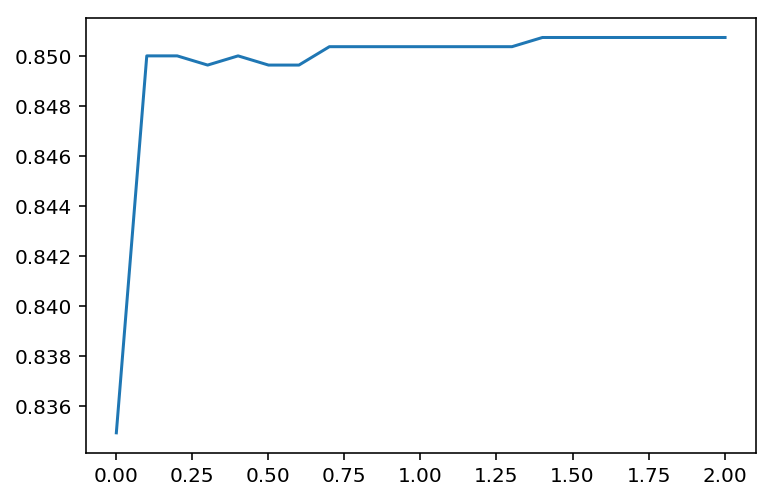

In [29]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

На&nbsp;тестовом наборе данных картина ровно та же:

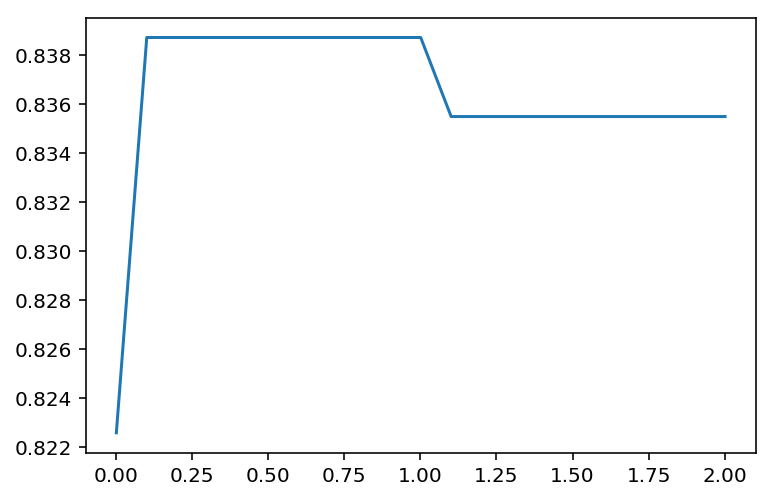

In [30]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

### SVM

Введем список настраиваемых параметров:

In [31]:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'gamma': param_range}]
tuned_parameters

[{'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

Запустим подбор параметра:

In [32]:
gs = GridSearchCV(SVC(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10),
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

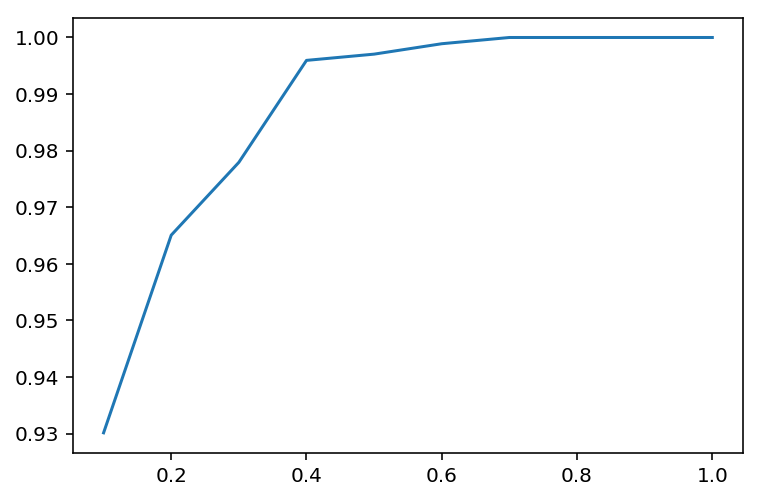

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше, но не глобально. При&nbsp;этом также видно, что разработчики библиотеки scikit-learn провели хорошую работу: получившееся оптимальное значение $\nu=0{,}5$ является стандартным для&nbsp;данного алгоритма<cite data-cite="doc:sklearn"></cite>.

На&nbsp;тестовом наборе данных картина ровно та же:

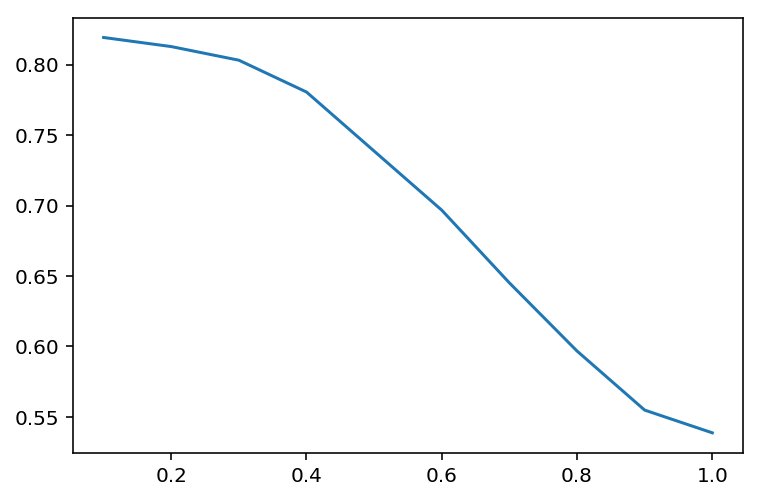

In [34]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Так как параметры подобраны те же, то и обучение модели заново производить не&nbsp;будем.

### Дерево решений

Введем список настраиваемых параметров:

In [35]:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

Запустим подбор параметра:

In [36]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

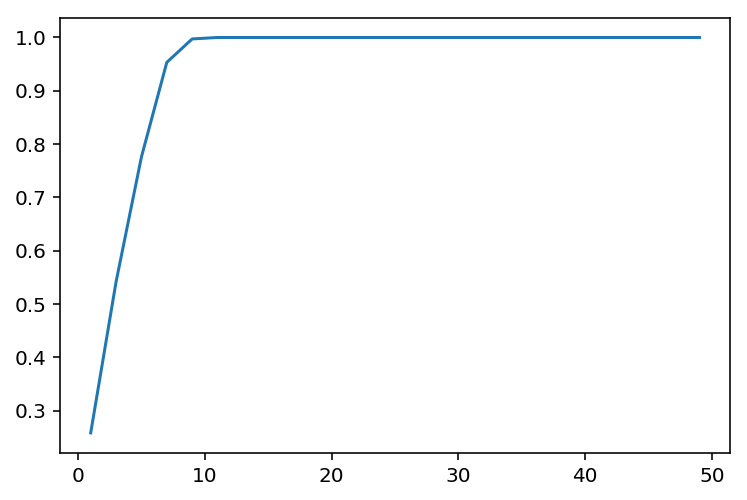

In [37]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что на&nbsp;тестовой выборке модель легко переобучается.

На&nbsp;тестовом наборе данных картина интереснее:

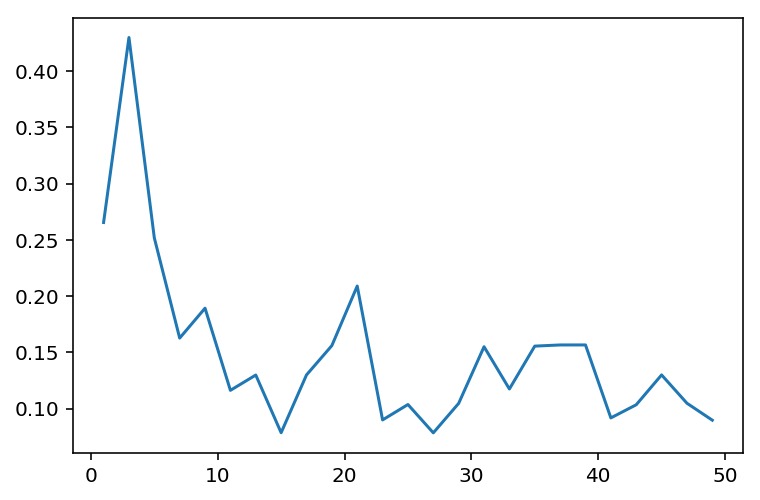

In [38]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в&nbsp;районе пика.

In [39]:
param_range = np.arange(7, 14, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 7,  8,  9, 10, 11, 12, 13])}]

In [40]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

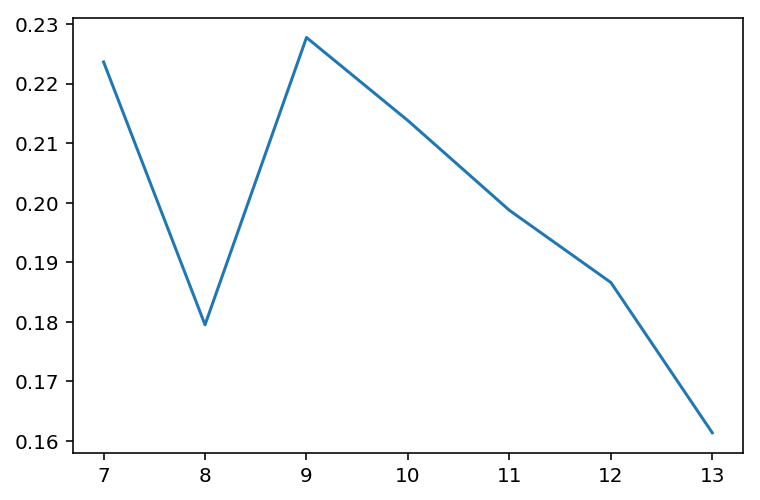

In [41]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Получили, что глубину дерева необходимо ограничить 10&nbsp;уровнями. Проверим этот результат.

In [42]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.2631578947368421
median_absolute_error: 0.0
accuracy: 0.7368421052631579
balanced_accuracy: 0.7426523297491039


In [43]:
X_train

array([[-1.1432911 ,  0.68100522, -0.93851463, ...,  0.97635214,
         0.26508221, -0.51292188],
       [ 0.29046364,  0.68100522,  1.00257707, ...,  0.97635214,
         0.26508221,  1.12302895],
       [ 0.84190778, -1.46841752, -0.93851463, ..., -2.27457861,
         2.22410436,  1.12302895],
       ...,
       [ 0.40075247,  0.68100522, -0.93851463, ...,  0.97635214,
        -0.71442887,  1.12302895],
       [-0.26098049,  0.68100522,  1.97312292, ..., -0.64911323,
        -0.71442887, -2.14887271],
       [-0.26098049,  0.68100522, -0.93851463, ...,  0.97635214,
         0.26508221, -0.51292188]])

Вновь посмотрим статистику получившегося дерева решений.

In [44]:
stat_tree(reg)

Всего узлов: 71
Листовых узлов: 36
Глубина дерева: 9
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 6.083333333333333


В&nbsp;целом получили примерно тот же результат. Коэффициент детерминации оказался немного выше, тогда как абсолютные ошибки также стали немного выше. Видно, что дерево решений достигло своего предела. При&nbsp;этом весьма поразительно, насколько хорошо данный метод решил задачу регрессии. Посмотрим на&nbsp;построенное дерево.

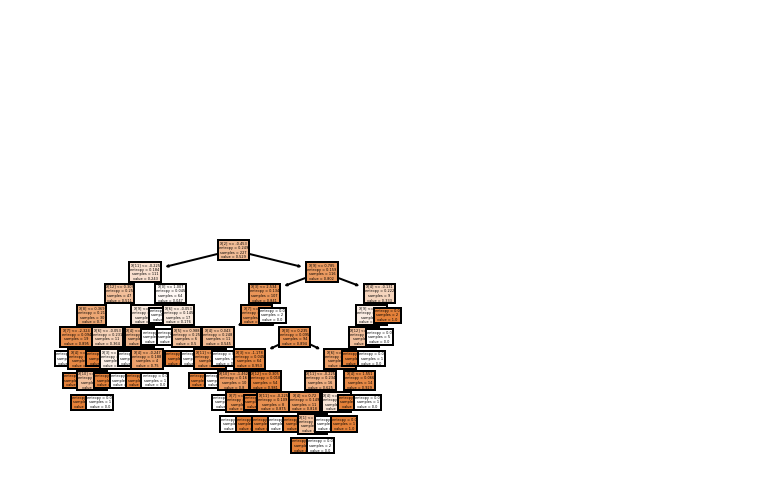

In [45]:
plot_tree(reg, filled=True);

Вывод функции `plot_tree` выглядит весьма странно. Видимо, для&nbsp;настолько больших деревьев решений она не&nbsp;предназначена. Возможно, это со&nbsp;временем будет исправлено, так как эту функциональность только недавно добавили.

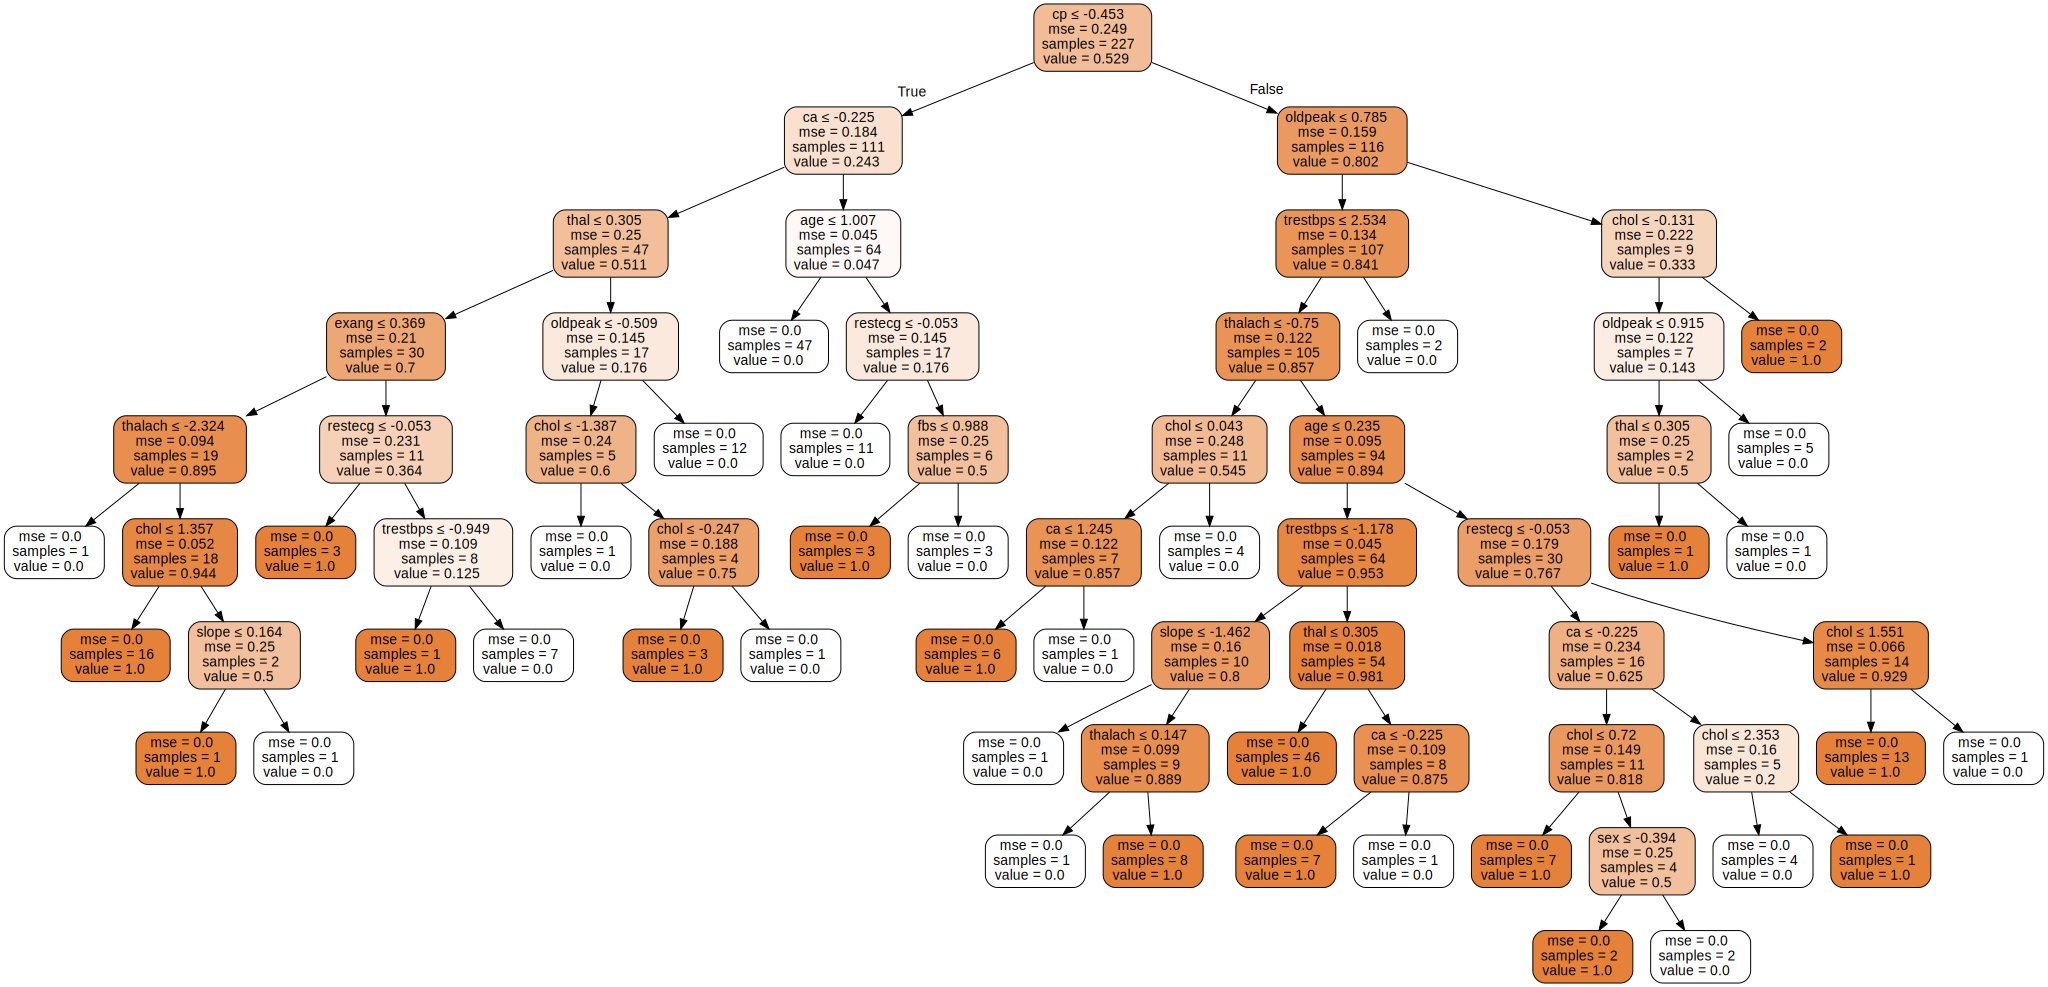

In [47]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Такое дерево уже можно анализировать. Видно, что сгенерировалось огромное множество различных условий, и, фактически, модель переобучена, но с&nbsp;другой стороны дерево решений и не&nbsp;могло быть построено иначе для&nbsp;задачи регрессии. К&nbsp;тому же на&nbsp;тестовой выборке данное дерево работает также довольно хорошо, так что, возможно, оно имеет право на&nbsp;существование. Если бы стояла задача классификации, то дерево решений явно показало бы себя просто отлично.